# Visualise dataset, Normalise Images, Save as .npy

### For Colab Start Here

In [1]:
from datetime import time

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Mask-Or-No-Mask'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset', 'Personal_Dataset', 'Models', '.DS_Store', '.git', '.gitattributes', '.idea', 'Labs', 'readme.md', 'dataset_as_pkl', '.gitignore', 'test_function.ipynb']


### For PyCharm Start Here

In [3]:
import os
import random
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import cv2
import time
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from skimage.feature import hog
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, cohen_kappa_score, f1_score
from sklearn.preprocessing import StandardScaler

### Make sure to comment out the Paths depending on IDE (PyCharm or Colab)

In [4]:

# Path to images and labels
# -------------------------- Paths for PyCharm --------------------------

# DATASET_PATH = "../CW_Dataset"

# TRAIN_IMAGE_PATH = "../CW_Dataset/train/images"
# TRAIN_LABEL_PATH = "../CW_Dataset/train/labels"
# TEST_IMAGE_PATH = "../CW_Dataset/test/images"
# TEST_LABEL_PATH = "../CW_Dataset/test/labels"
# TRAIN_FLOAT32_PATH = "../dataset_as_pkl/normalized_float32_train.pkl"
# TEST_FLOAT32_PATH = "../dataset_as_pkl/normalized_float32_test.pkl"
# TRAIN_UINT8_PATH = "../dataset_as_pkl/normalized_uint8_train.pkl"
# TEST_UINT8_PATH = "../dataset_as_pkl/normalized_uint8_test.pkl"
# VAL_FLOAT32_PATH = "../dataset_as_pkl/normalized_float32_val.pkl"
# VAL_UINT8_PATH = "../dataset_as_pkl/normalized_uint8_val.pkl"
# HOG_FEATURES = "../dataset_as_pkl/hog_train.pkl"
# HOG_TEST_FEATURES = "../dataset_as_pkl/hog_test.pkl"
# SIFT_TEST_FEATURES = "../dataset_as_pkl/sift_test.pkl"
# SIFT_FEATURES = "../dataset_as_pkl/sift_train.pkl"
# MODEL_HOG_SVM = "../Models/hog_svm_model.pkl"
# MODEL_SIFT_HOG_MLP = "../Models/hog_sift_mlp_model.pkl"
# MODEL_CNN = "../Models/CNN_model.pt"

# HOG_SVM_METRICS = "../Models/Model_metrics/hog_svm_metrics.pkl"
# SIFT_HOG_MLP_METRICS_PATH = "../Models/Model_metrics/hog_sift_mlp_metrics1.pkl"
# CNN_METRICS = "../Models/Model_metrics/CNN_metrics.pkl"

# -------------------------- Paths for PyCharm --------------------------

# -------------------------- Paths for Colab --------------------------

DATASET_PATH = "/content/drive/MyDrive/Mask-Or-No-Mask/CW_Dataset"
MODEL_PATHS = "/content/drive/MyDrive/Mask-Or-No-Mask/Models"
MODEL_METRICS_PATH = "/content/drive/MyDrive/Mask-Or-No-Mask/Models/Model_metrics"
SAVED_DATASET_PATH = "/content/drive/MyDrive/Mask-Or-No-Mask/dataset_as_pkl"

TRAIN_IMAGE_PATH = f"{DATASET_PATH}/train/images"
TRAIN_LABEL_PATH = f"{DATASET_PATH}/train/labels"
TEST_IMAGE_PATH = f"{DATASET_PATH}/test/images"
TEST_LABEL_PATH = f"{DATASET_PATH}/test/labels"
TRAIN_FLOAT32_PATH = f"{SAVED_DATASET_PATH}/normalized_float32_train.pkl"
TEST_FLOAT32_PATH = f"{SAVED_DATASET_PATH}/normalized_float32_test.pkl"
TRAIN_UINT8_PATH = f"{SAVED_DATASET_PATH}/normalized_uint8_train.pkl"
TEST_UINT8_PATH = f"{SAVED_DATASET_PATH}/normalized_uint8_test.pkl"
VAL_FLOAT32_PATH = f"{SAVED_DATASET_PATH}/normalized_float32_val.pkl"
VAL_UINT8_PATH = f"{SAVED_DATASET_PATH}/normalized_uint8_val.pkl"
HOG_FEATURES = f"{SAVED_DATASET_PATH}/hog_train.pkl"
HOG_VAL_FEATURES = f"{SAVED_DATASET_PATH}/hog_val.pkl"
SIFT_VAL_FEATURES = f"{SAVED_DATASET_PATH}/sift_val.pkl"
SIFT_FEATURES = f"{SAVED_DATASET_PATH}/sift_train.pkl"
HOG_TEST_FEATURES = f"{SAVED_DATASET_PATH}/hog_test.pkl"
SIFT_TEST_FEATURES = f"{SAVED_DATASET_PATH}/sift_test.pkl"
MODEL_HOG_SVM = f"{MODEL_PATHS}/hog_svm_model.pkl"
MODEL_SIFT_HOG_MLP = f"{MODEL_PATHS}/hog_sift_mlp_model.pkl"
MODEL_CNN = f"{MODEL_PATHS}/CNN_model.pt"

HOG_SVM_METRICS = f"{MODEL_METRICS_PATH}/hog_svm_metrics.pkl"
SIFT_HOG_MLP_METRICS = f"{MODEL_METRICS_PATH}/hog_sift_mlp_metrics.pkl"
CNN_METRICS = f"{MODEL_METRICS_PATH}/CNN_metrics.pkl"

# -------------------------- Paths for Colab --------------------------


# Load features helper function

In [5]:
def load_features(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)

# Displaying 6 random images from dataset to see what we are working with

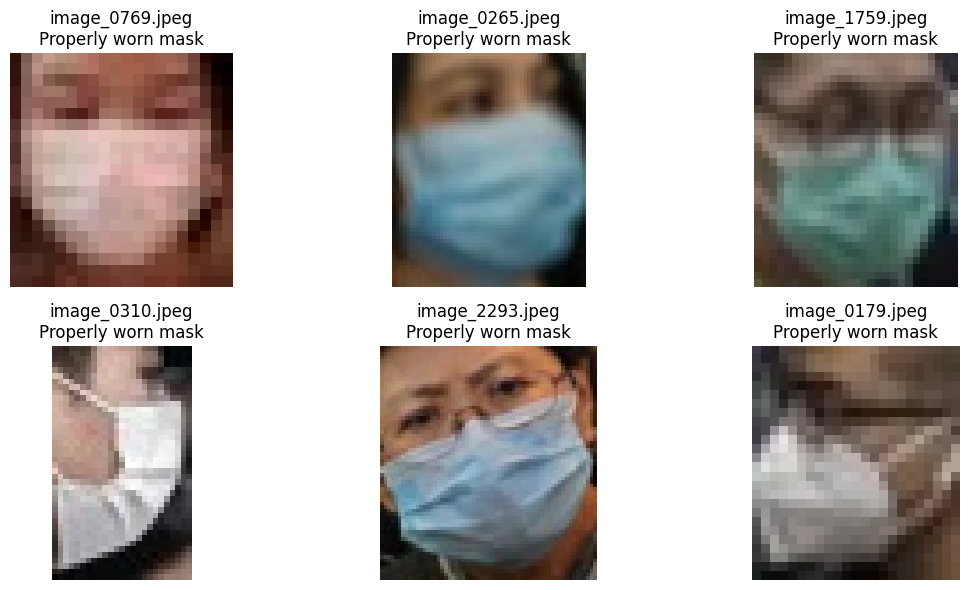

In [ ]:
def show_random_images(ip, lp):
    # Map to associate value with category
    label_map = {
        '0': "No mask",
        '1': "Properly worn mask",
        '2': "Improperly worn mask"
    }

    # Get all images
    image_files = [f for f in os.listdir(ip) if f.lower().endswith('.jpeg')]

    # Select random images
    num_samples = 6
    sampled_images = random.sample(image_files, num_samples)

    # Plot
    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(ip, img_name)

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB for matplotlib

        # Find label for image
        label_filename = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(lp, label_filename)

        # Read label
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label_index = f.read().strip()
            label_text = label_map.get(label_index, "Unknown label")
        else:
            label_text = 'Unknown label'

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"{img_name}\n{label_text}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(TRAIN_IMAGE_PATH, TRAIN_LABEL_PATH)

- Initially thought of using padding to make all images the same size
- Realised this might cause issues with edge detection, because of the sharp border of the black/white pixels I will be adding
	- This could cause big issues down the line with feature descriptors
- Thought about adding padding then using a pre-trained face detection model to crop into the faces and pull a consistent size
- Realised, if I'm using face detection, then why bother adding padding as the face detection should only pull the face regardless of image size.
- Options
	- OpenCV Haar Cascade Classifier
	- OpenCV DNN Face Detection
	- dlib.get_frontal_face()
- Decided on using OpenCVs DNN Face Detection model
- Learnt that that model needs images of at least 100x100 to be nicely accurate
- Realised, that due to the vast different in the sizes of the images even if the image size wasn't an issue, the face detection model would probably poorly handle up/downscaling of the images

- Going to write code to allow me to find the frequency of the sizes of the images and visualise them, that way I can choose the best size to normalise too. I.e.
	- Most images are in the range 10x10 - 70x70 then 64x64 seems fitting
	- Most images are in the range 100x100 - 150x150 then 128x128 seems fitting


# Visualizing spread of image sizes

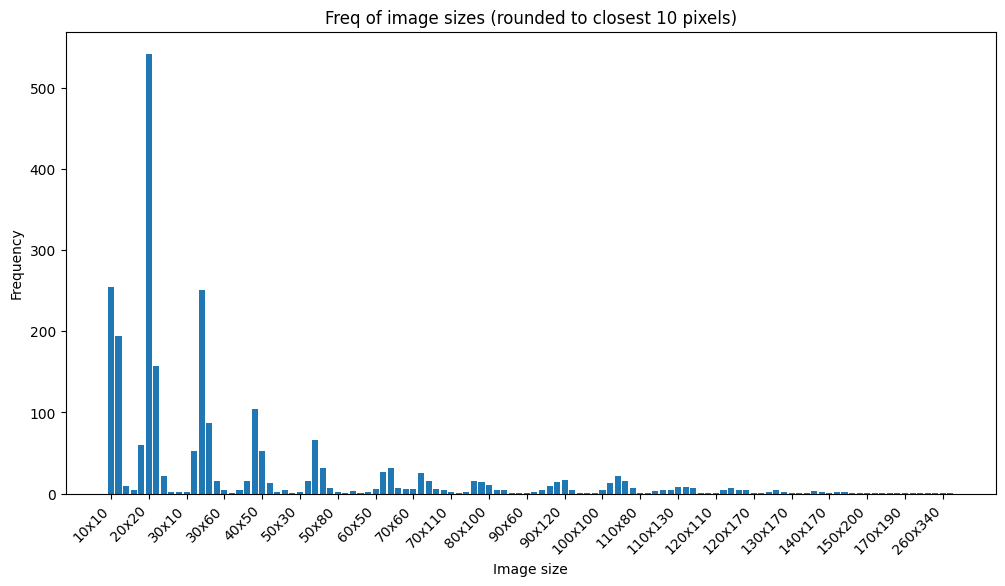

In [ ]:
image_sizes = []

for filename in os.listdir(TRAIN_IMAGE_PATH):
    if filename.lower().endswith('.jpeg'):
        img_path = os.path.join(TRAIN_IMAGE_PATH, filename)
        img = cv2.imread(img_path)

        if img is not None:
            h, w = img.shape[:2]
            rounded_sizes = (w // 10 * 10, h // 10 * 10)
            image_sizes.append(rounded_sizes)

counter = Counter(image_sizes)

sorted_sizes = sorted(counter.items(), key=lambda x: (x[0][0], x[0][1]))
labels = [f"{w}x{h}" for (w, h), _ in sorted_sizes]
counts = [count for _, count in sorted_sizes]

skip = 5

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.xticks(ticks = range(0, len(labels), skip), labels = labels[::skip], rotation = 45, ha = 'right')
plt.title('Freq of image sizes (rounded to closest 10 pixels)')
plt.xlabel('Image size')
plt.ylabel('Frequency')
plt.show()


- Based on the results from the visualisation I can see that most of the images are on the smaller side therefore I will go 64x64.
	- I questioned whether I should choose a rectangular size rather than square but upon research learned that
	    - 64x64 is somewhat of a standard
	    - It is best for model compatibility
	    - Allows for uniform cell layout for HOG descriptors
	    - can easily augment the image (flip/rotate)
	    - etc.

- Adding padding to the image
    - Maintaining aspect ratio
    - Centering image
    - Padding colour will be black

- Loading normalized images
    - Make images greyscale
    - Normalize pixel values
    - Save all the images as np.array so I don't have to do this every time
    - Add the images and labels to lists for ease of use



# Select path

In [ ]:
def select_path(dataset_name="train", data_type="float32"):
    # Choose paths based on train or test data
    if dataset_name == "train" and data_type == "float32":
        chosen_path = load_features(TRAIN_FLOAT32_PATH)
    elif dataset_name == "train" and data_type == "uint8":
        chosen_path = load_features(TRAIN_UINT8_PATH)
    elif dataset_name == "test" and data_type == "float32":
        chosen_path = load_features(TEST_FLOAT32_PATH)
    elif dataset_name == "test" and data_type == "uint8":
        chosen_path = load_features(TEST_UINT8_PATH)
    else:
        raise ValueError("dataset_name must be 'train' or 'test'")

    return chosen_path

# Display 6 random normalized images from .pkl

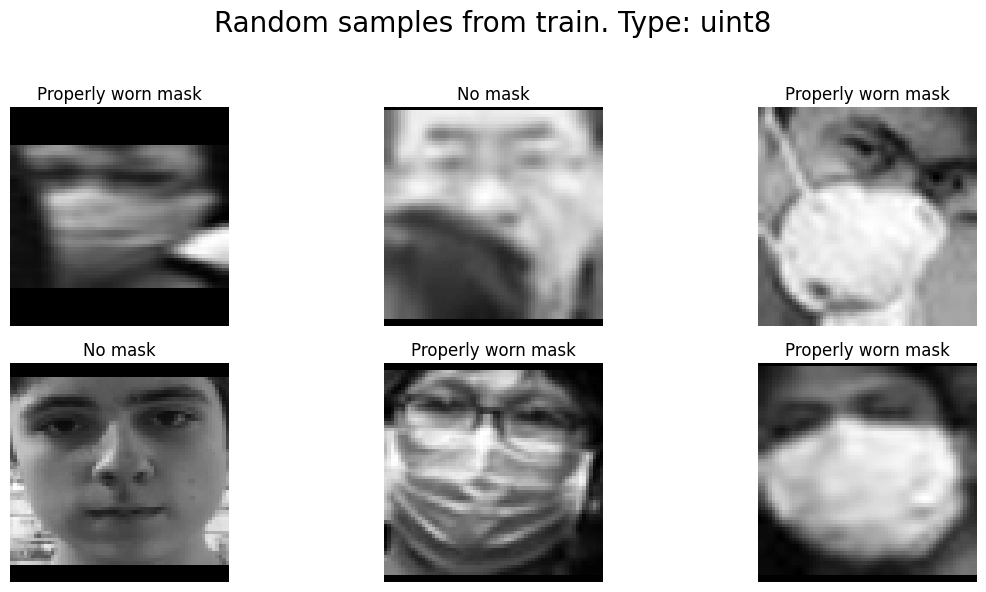

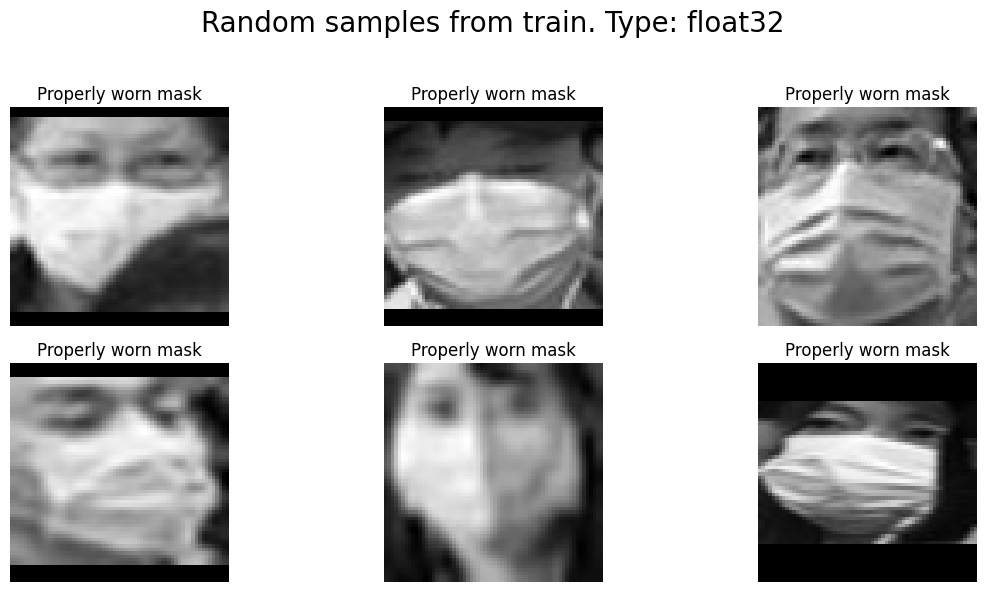

In [ ]:

def show_random_normalized_images(label_map=None, num_samples=6, dataset_name="train", data_type="float32"):
    X, y = select_path(dataset_name, data_type)

    # Match the labels with the correct categories
    if label_map is None:
        label_map = {
            0: "No mask",
            1: "Properly worn mask",
            2: "Improperly worn mask"
        }

    # Randomly select the images from the dataset
    indices = random.sample(range(len(X)), num_samples)

    # Create the grid to display images
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Random samples from {dataset_name}. Type: {data_type}', fontsize=20)

    for i, idx in enumerate(indices):
        img = X[idx]
        label = y[idx]
        label_text = label_map.get(label, "Unknown")

        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze()

        plt.subplot(2, 3, i + 1)
        plt.gca().set_facecolor('white')
        plt.imshow(img, cmap='gray')
        plt.title(label_text)
        plt.axis('off')

    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()

show_random_normalized_images(dataset_name="train", data_type="uint8")
show_random_normalized_images(dataset_name="train", data_type="float32")

# Visualising HOG features

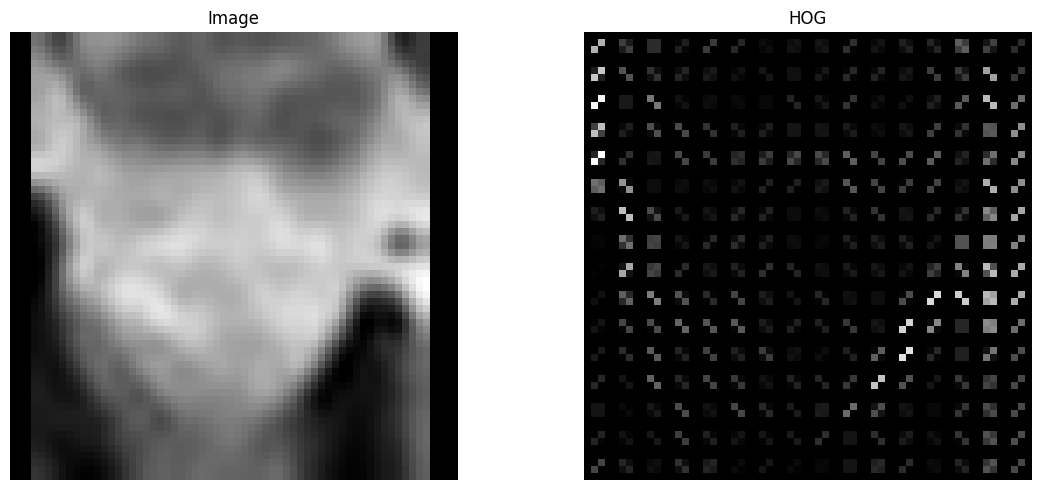

In [ ]:
"""
Visualization techniques for HOG were adapted from Lab 5
"""

def visualize_hog(image):
    # Compute HOG descriptor (feature vector)
    hog_descriptor, hog_image = hog(
        image,
        orientations = 8,
        pixels_per_cell = (4, 4),
        cells_per_block = (2, 2),
        block_norm = "L2-Hys",
        visualize = True
    )

    # Plot image and HOG
    plt.figure(figsize = (12, 5))

    # Image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')
    plt.axis('off')

    # HOG
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap = 'gray')
    plt.title("HOG")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

X, y = load_features(TRAIN_FLOAT32_PATH)
sample_image = random.choice(X)
visualize_hog(sample_image)

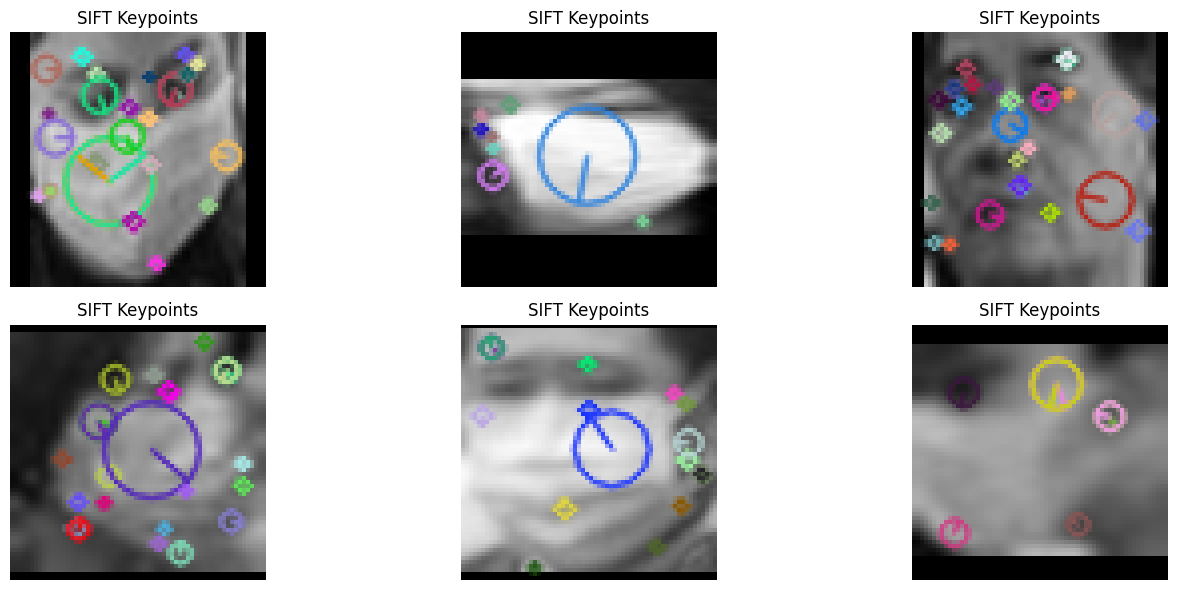

In [ ]:
"""
Visualization techniques for HOG were adapted from Lab 6
"""
def visualize_sift(dataset="train", num_samples=6):
    if dataset == "train":
        X, y = load_features(TRAIN_UINT8_PATH)
    elif dataset == "test":
        X, y = load_features(TEST_UINT8_PATH)
    else:
        raise ValueError("dataset must be 'train' or 'test'")

    sift = cv2.SIFT_create()
    indices = random.sample(range(len(X)), min(num_samples, len(X)))

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img = X[idx]
        kp, _ = sift.detectAndCompute(img, None)
        img_with_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img_with_kp, cmap='gray')
        plt.title("SIFT Keypoints")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_sift("train")

[0] ORB keypoints: 0
[1] ORB keypoints: 0
[2] ORB keypoints: 0
[3] ORB keypoints: 0
[4] ORB keypoints: 0
[5] ORB keypoints: 0


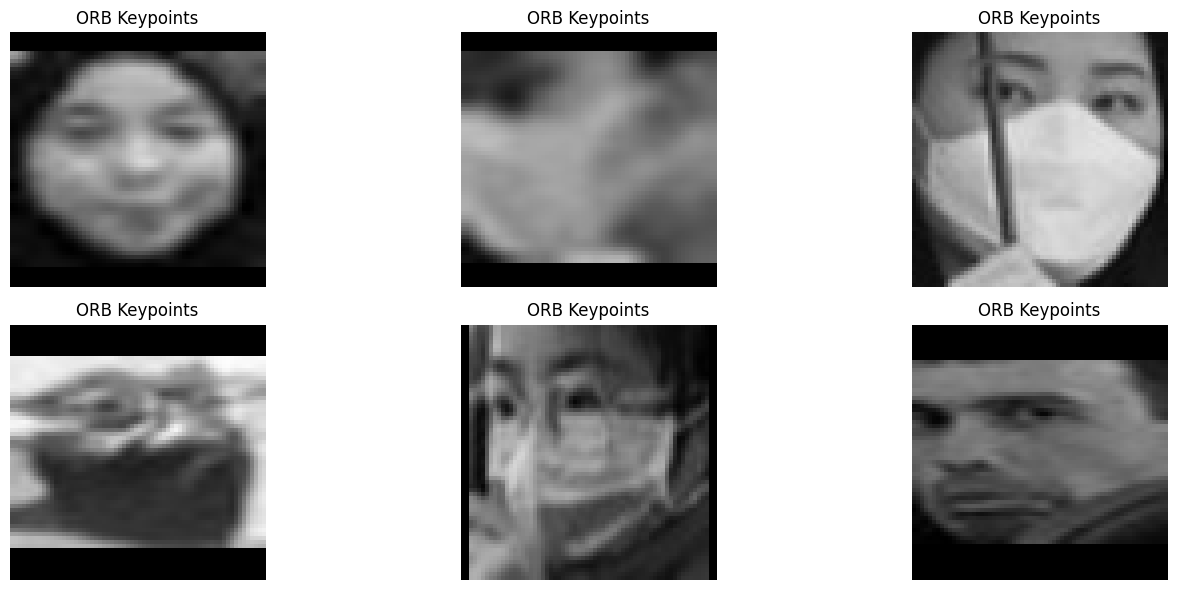

In [ ]:
def visualize_orb(dataset="train", num_samples=6):
    if dataset == "train":
        X, y = load_features(TRAIN_UINT8_PATH)
    elif dataset == "test":
        X, y = load_features(TEST_UINT8_PATH)
    else:
        raise ValueError("dataset must be 'train' or 'test'")

    orb = cv2.ORB_create(nfeatures=1000, fastThreshold=5)
    indices = random.sample(range(len(X)), min(num_samples, len(X)))

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img = X[idx]
        kp, _ = orb.detectAndCompute(img, None)
        print(f"[{i}] ORB keypoints: {len(kp)}")
        img_with_kp = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img_with_kp, cmap='gray')
        plt.title("ORB Keypoints")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_orb("train")

# Confusion matrix function

In [6]:
def plot_confusion_matrix(test_y, y_pred, labels, title="Confusion Matrix", model_name="Model", inference_time=None):
    cm = confusion_matrix(test_y, y_pred)
    acc = accuracy_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred, average="macro")
    kappa = cohen_kappa_score(test_y, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"{title} for {model_name}")
    plt.show()

    # Print classification metrics
    print(f"{model_name} Results")
    print(f"Accuracy: {acc:.4f}\n")
    print(f"F1 score (macro): {f1:.4f}\n")
    print(f"Kappa: {kappa:.4f}\n")
    print(f"Inference time: {inference_time:.4f}s\n")
    print(classification_report(test_y, y_pred, target_names=[str(label) for label in labels], zero_division=0))


# HOG-SVM model

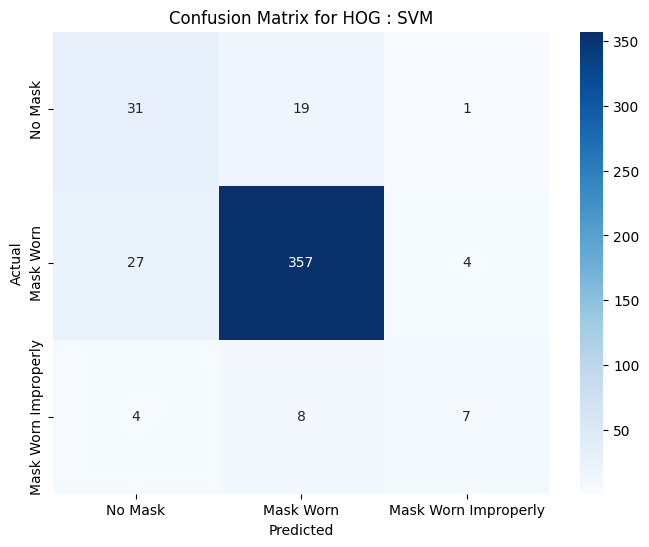

HOG : SVM Results
Accuracy: 0.8624

F1 score (macro): 0.6417

Kappa: 0.4972

Inference time: 14.7746s

                      precision    recall  f1-score   support

             No Mask       0.50      0.61      0.55        51
           Mask Worn       0.93      0.92      0.92       388
Mask Worn Improperly       0.58      0.37      0.45        19

            accuracy                           0.86       458
           macro avg       0.67      0.63      0.64       458
        weighted avg       0.87      0.86      0.86       458



In [ ]:
def evaluate_hog_svm(test_path = HOG_TEST_FEATURES, model_path = MODEL_HOG_SVM, labels = None):
    if labels is None:
        labels = ["No Mask", "Mask Worn", "Mask Worn Improperly"]

    # Load HOG features and labels from test .pkl
    with open(test_path, "rb") as f:
        test_X, test_y = pickle.load(f)

    # Load the trained model
    with open(model_path, "rb") as f:
        model = pickle.load(f)

    start_inference_time = time.time()
    # Predict and plot
    y_pred = model.predict(test_X)
    inference_time = time.time() - start_inference_time

    plot_confusion_matrix(test_y, y_pred, labels=labels, model_name="HOG : SVM", inference_time=inference_time)

evaluate_hog_svm()

# HOG-SIFT-MLP model

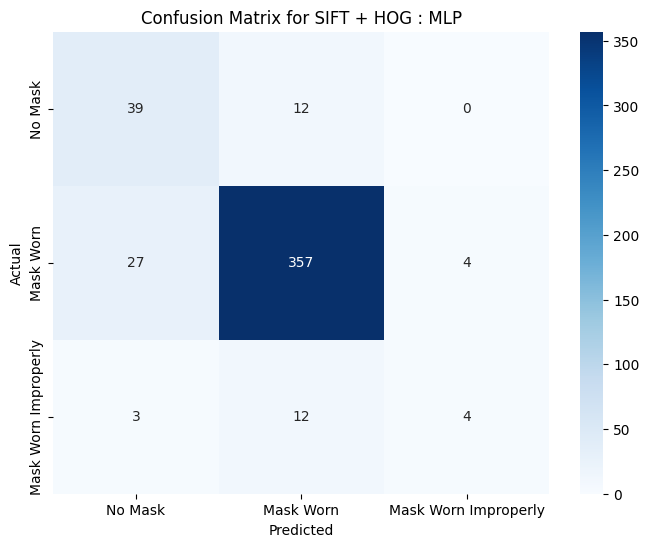

SIFT + HOG : MLP Results
Accuracy: 0.8734

F1 score (macro): 0.6249

Kappa: 0.5441

Inference time: 0.2037s

                      precision    recall  f1-score   support

             No Mask       0.57      0.76      0.65        51
           Mask Worn       0.94      0.92      0.93       388
Mask Worn Improperly       0.50      0.21      0.30        19

            accuracy                           0.87       458
           macro avg       0.67      0.63      0.62       458
        weighted avg       0.88      0.87      0.87       458



In [ ]:
def combine_hog_sift(hog_input, sift_input):
    X_hog, y = hog_input
    X_sift, _ = sift_input  # y already loaded from HOG

    # Same processing as in training
    X_sift = [np.mean(x, axis=0) if x is not None else np.zeros(128) for x in X_sift]
    X_sift = np.stack(X_sift)
    X_hog = np.array(X_hog)

    combined = np.concatenate([X_hog, X_sift], axis=1)
    return combined, np.array(y)

def evaluate_hog_sift_mlp(hog_test_path = HOG_TEST_FEATURES, sift_test_path = SIFT_TEST_FEATURES, model_path = MODEL_SIFT_HOG_MLP, labels=None):
    if labels is None:
        labels = ["No Mask", "Mask Worn", "Mask Worn Improperly"]

    # Load test features
    test_X, test_y = combine_hog_sift(load_features(hog_test_path), load_features(sift_test_path))

    # Load model
    with open(model_path, "rb") as f:
        model = pickle.load(f)

    scaler = StandardScaler()
    test_X = scaler.fit_transform(test_X)

    # Predict and plot
    start_inference_time = time.time()
    y_pred = model.predict(test_X)
    inference_time = time.time() - start_inference_time
    plot_confusion_matrix(test_y, y_pred, labels = labels, model_name="SIFT + HOG : MLP", inference_time = inference_time)

evaluate_hog_sift_mlp()

# CNN model

Accuracy: 0.9301
Cohen’s Kappa: 0.7435
Log Loss: 0.2336


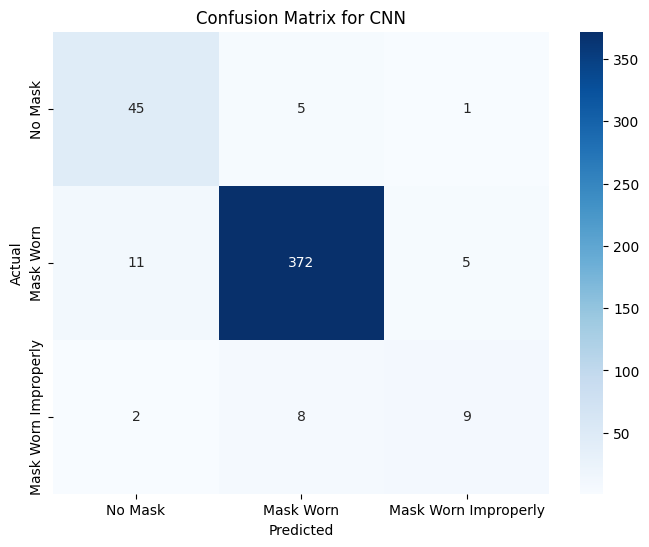

CNN Results
Accuracy: 0.9301

F1 score (macro): 0.7725

Kappa: 0.7435

Inference time: 0.9241s

                      precision    recall  f1-score   support

             No Mask       0.78      0.88      0.83        51
           Mask Worn       0.97      0.96      0.96       388
Mask Worn Improperly       0.60      0.47      0.53        19

            accuracy                           0.93       458
           macro avg       0.78      0.77      0.77       458
        weighted avg       0.93      0.93      0.93       458



In [7]:
import torch.nn as nn

def load_features(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)

def my_CNN(dropout_rate = 0.2):
    class face_mask_CNN(nn.Module):
        def __init__(self, num_classes = 3):
            super(face_mask_CNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64 * 8 * 8, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, num_classes),
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    return face_mask_CNN()

class load_from_pkl(Dataset):
    def __init__(self, data_path):
        self.X, self.y = load_features(data_path)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx].reshape(1,64,64)
        return torch.tensor(img, dtype = torch.float32), torch.tensor(self.y[idx], dtype = torch.long)

def get_data_loaded(test_path, batch_size=64):
    test_dataset = load_from_pkl(test_path)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def evaluate_cnn(test_loader, model, model_path = MODEL_CNN, labels=None):
    if labels is None:
        labels = ["No Mask", "Mask Worn", "Mask Worn Improperly"]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    y_probs = []

    start_inference_time = time.time()

    with torch.no_grad():
        for images, labels_batch in test_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    inference_time = time.time() - start_inference_time

    # Convert to numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    logloss = log_loss(y_true, y_probs)

    # Output metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Cohen’s Kappa: {kappa:.4f}")
    print(f"Log Loss: {logloss:.4f}")

    # Plot Confusion Matrix
    plot_confusion_matrix(test_y = y_true, y_pred = y_pred, labels = labels, model_name="CNN", inference_time = inference_time)

model = my_CNN(dropout_rate=0.2)
model.load_state_dict(torch.load(MODEL_CNN))


test_path = TEST_FLOAT32_PATH
test_loader = get_data_loaded(test_path, batch_size=64)
evaluate_cnn(test_loader, model)
